# Worked Tutorial on Solar Cells

## Introduction

**Organic photovoltaic (OPV)** are ‘plastic’ solar cells that can be made cheaply and easily as you can use techniques like roll to roll printing, inject printing and spray coating. Current generation solar cells take several years of use before they payback the energy required in their manufacture, OPVs are so efficient that their energy payback is only 24hours. **Power conversion efficiencies (PCEs)** of OPVs are now around 14%. To commercialise them, we need to figure out how best to manufacture them.

Organic photovoltaic devices have a sandwich architecture. The bottom layers Al/Mg and LiF are the bottom electrode. The important part is the bulk hetereojunction, shown in red in the figure below, which comprises of a low band gap polymer which is the electron donor and fullerene which is the electron acceptor. Addition of an additive helps with forming and bridging separate nanodomains of donor and accceptor. Solar cells work by using light to form an exciton which then separates into an electron-hole pair and you want these to be separated from each other, which is why you want separate nanodomain of donor and acceptor. The top of the solar cell is PEDOT:PSS (a conducting polymer) and ITO  (indium tin oxide), a see-through electrode, which together act as the top electrode. 

![Test_HetJunc.jpeg](Test_HetJunc.jpeg)

Figure 1. (a) Schematic of single junction organic photovoltaic (OPV) devices, showing the bulk heterojunction (BHJ; in red), and the multiple interfacial layers in the device. (b) Schematic of BHJ morphology: in this case, a low band gap polymer donor and a fullerene acceptor undergoing nanoscale phase segregation into discrete nanoscale domains of donor and acceptor. The use of an additive is often purported to assist in nanodomain formation, as shown here. Taken from [ACS Nano 2018, 12, 7434−7444]





## The task

The task is to optimise the construction of this type of solar cell. Donor weight percentage is a measure of the ratio of donor to acceptor in the heterojunction.  Total solution concentration is the concentration of the spin-coating solution. Bulk heterojunction spin-case speed is a measure of how fast you spin the device when coating it with the bulk heterojunction mixture. Processing additive is the amount of additive (diiodooctane) added to the mixture. The thickness of a spun film is determined by the spin speed, solvent vapour pressure and solution viscosity, as both the donor weight percentage and total solution concentration can affect viscosity, the first three factors can all affect the thickness of the final BHJ layer. The additive (diiodooctane) increases the drying time for the film, helping to separate the hetereojunction out into nanodomains of donor and acceptor rich areas. 


## Factors selected:

| Name  |   Factors                         |Factor range   | No. of levels  |
|-------|-----------------------------------|---------------|----------------|
| Donor | Donor weight percentage          | 10-55 (wt %)         | 4       |
| Conc. | Total solution concentration     | 10-25 (mg/mL)        | 4       |
| Spin  | Bulk heterojunction spin-case speed | 600 - 3000  (rpm) | 4       |
| Add.  | Processing additive              |  0-12 (vol %)        | 4       | 

We shall use the shortened names from the table above. 

## Response selected: 

Power conversion efficiencies (PCE) which is a percentage and measures how efficiently incident light is converted to electricity.

## Files: 

1. `solar_cells_1.csv` results from the first experiment, fractional factorial, 4 factors and 4 levels, here we have 16 experiments, one failed to solidify. 
2. `solar_cells_2.csv` has results from the second experiment, a fractional factorial, 3 factors and 3 levels. This covers a smaller range. 

The data is taken from: 
"How To Optimize Materials and Devices via Design of Experiments and Machine Learning: Demonstration Using Organic Photovoltaics", Bing Cao, Lawrence A. Adutwum, Anton O. Oliynyk, Erik J. Luber, Brian C. Olsen, Arthur Mar, and Jillian M. Buriak, ACS Nano 2018, 12, 7434−7444

### Importing packages

In [1]:
# for dataframes
import pandas as pd

# for pictures
import matplotlib.pyplot as plt

# for maths
import numpy as np

import doenut

# set the log level
import logging
doenut.set_log_level(logging.WARNING)

### Read in the first experiment's data

In [2]:
df = pd.read_csv("data/solar_cells_1.csv")
df

,experiment #,donor percentage,total concentration,spin speed,additive,PCE,std of PCE (%),number of devices
0,NaN,% (wt),mg/mL,rpm,vol %,%,NaN,NaN
1,1-1,10,20,3000,2,0.05,5.0,14.0
2,1-2,10,25,1000,8,3.24,11.0,10.0
3,1-3,10,10,600,0,0.016,16.0,14.0
4,1-4,10,15,2000,12,0.0004,4.0,10.0
5,1-5,25,20,600,12,7.14,13.0,8.0
6,1-6,25,15,1000,2,3.22,32.0,8.0
7,1-7,25,10,3000,8,0.00033,7.0,14.0
8,1-8,25,25,2000,0,7.21,17.0,11.0
9,1-9,40,10,1000,12,1.85,5.0,3.0


### Set up input and response dataframes

We must drop the last experiment, as these devices didn't set.

In [3]:
inputs = pd.DataFrame(
    {
        "Donor %": [float(x) for x in df.iloc[1:-1, 1]],
        "Conc.": [float(x) for x in df.iloc[1:-1, 2]],
        "Spin": [float(x) for x in df.iloc[1:-1, 3]],
        "Add.": [float(x) for x in df.iloc[1:-1, 4]],
    }
)
inputs

,Donor %,Conc.,Spin,Add.
0,10.0,20.0,3000.0,2.0
1,10.0,25.0,1000.0,8.0
2,10.0,10.0,600.0,0.0
3,10.0,15.0,2000.0,12.0
4,25.0,20.0,600.0,12.0
5,25.0,15.0,1000.0,2.0
6,25.0,10.0,3000.0,8.0
7,25.0,25.0,2000.0,0.0
8,40.0,10.0,1000.0,12.0
9,40.0,20.0,2000.0,8.0


In [4]:
responses = pd.DataFrame({"PCE": [float(x) for x in df["PCE"][1:-1]]})
responses

,PCE
0,0.05000
1,3.24000
2,0.01600
3,0.00040
4,7.14000
5,3.22000
6,0.00033
7,7.21000
8,1.85000
9,6.16000


# Task 1. Create a linear (main factors only) model

Create a linear model, i.e. a model that has just the main effects (also known as a first order model or main effects model) Fit your linear model to the first experiment’s data and calculate $R^2$ and $Q^2$ for your fitted model. Then answer the questions

#### Question 1.1 For the first screening experiment, (solar_cells_1), if the experimentalists had chosen to do a full factorial experiment, rather than a fractional factorial experiment, excluding repeats and centrepoints, how many experiments would they have had to do? (1 mark)

* **A**. Two levels, four factors, $2^4 = 16$.
* **B**. Four levels, four factors, $4^4 = 256$.
* **C**. Four levels, two factors, $4^2 = 16$.
* **D**. Two levels, three factors, $2^3 = 8$.
* **E**. Three levels, three factors, $3^3 = 27$. 



#### Question 1.2 What terms are in the linear (main terms only) model? (1 mark)

* **A**. Donor, Conc, Spin, Donor$^2$, Donor$\times$Spin, Conc.$\times$Spin
* **B**. Donor, Conc., Spin, Add, Donor$\times$Spin, Donor$\times$Add
* **C**. Donor, Conc., Spin and Add
* **D**. Donor, Conc., Spin, Add, Donor$^2$, Conc.$^2$, Spin$^2$, Add$^2$
* **E**. Donor, Conc., Spin, Add, Donor$^2$, Conc.$^2$, Spin$^2$, Add$^2$, Donor$\times$Conc., Donor$\times$Spin, Donor$\times$Add, Conc$\times$Spin, Conc.$\times$Add, Spin$\times$Add
* **F**  Donor, Conc., Spin, Donor$^2$, Conc.$^2$, Spin$^2$
* **G**. Donor, Conc., Spin, Add, Donor$\times$Conc., Donor$\times$Spin, Donor$\times$Add, Conc$\times$Spin, Conc.$\times$Add, Spin$\times$Add

#### Question 1.3 What is the $Q^2$ of the main effects model (1 mark)

* **A**.	-1.9
* **B**.	+0.014
* **C**.	0.17
* **D**.	0.604
* **E**.	0.871

#### Question 1.4: What is the biggest main effect in the main effect model? (1 mark)

- **A**. Donor
- **B**. Conc.
- **C**. Spin.
- **D**. Add



In [5]:
# First create a dataset object linking the inputs and responses.
data_set = doenut.data.ModifiableDataSet(inputs, responses)

# Second create and fit an AveragedModel
model = doenut.models.AveragedModel(data_set)
# Report the R^2 and Q^2 values
r2, q2 = model.r2, model.q2

print(f"R^2 is {r2:.2}, Q^2 is {q2:.2}")

R^2 is 0.6, Q^2 is 0.17


Input_selector was: [0, 1, 2, 3]
Average coefficients are: [ 6.85475012 10.85602224 -2.66214206  2.5458804 ]
Errors are [2. 2. 2. 2.]
Coefficient labels are: Index(['Donor %', 'Conc.', 'Spin', 'Add.'], dtype='object')


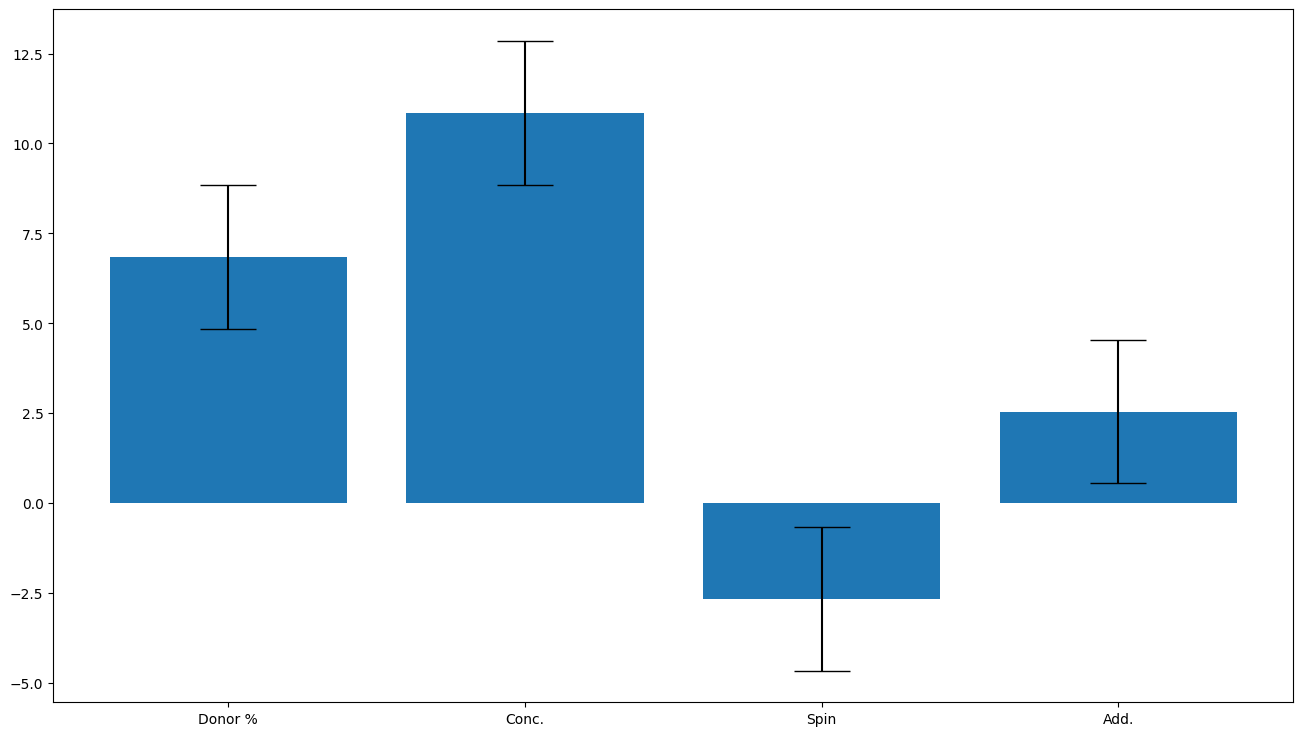

In [6]:
# Now lets look at the averaged coefficients for the fitted model.
doenut.plot.coeff_plot(model.coeffs, labels=inputs.columns, errors='p95', normalise=True)

### Task 1 Answers: 

#### Question 1.1 For the first screening experiment, (solar_cells_1), If the experimentalists had chosen to do a full factorial experiment, rather than a fractional factorial experiment, excluding repeats and centrepoints, how many experiments would they have had to do? (1 mark)

**Answer: B.** The number of experiments is given by $L^k$ where $L$ is the number of levels of each of the factors and $k$ is the number of factors. 

* B. Four levels, four factors, $4^4 = 256$.

#### Question 1.2 What terms are in the linear (main terms only) model? (1 mark)

**Answer: C.** The main terms are those that describe the input factors. The model is linear as it has no higher order terms, therefore there are no square or cross terms, therefore the model can only contain Donor, Conc, Spin and Add

* C. Donor, Conc., Spin and Add

#### Question 1.3 What is the $Q^2$ of the main effects model (1 mark)

**Answer: C.** 0.17. It’s not a great model

* C.	0.17

#### Question 1.4: What is the biggest main effect in the main effect model? (1 mark)

**Answer B.** Conc.  The coefficient plot gives the normalised coefficients so we can directly compare the effect of each factor on the system by comparing the size of the normalised coefficients. The largest coefficient is Conc. indicating that the concentration is the largest effect. (Also, the effect size is 2$\times$normalised coefficients). 

- B. Conc.

## Task 2. Create a square, parsimonious and hierarchical model (6 marks)

Create a **square**, **parsimonious** and **hierarchical** model. Starting with a quadratic model, **using only square terms, no interaction terms** and make sure that all models are hierarchical, optimise the model by removing **only** the **statistically insignificant** terms. Keep a note of the terms removed and the $R^2$ and $Q^2$ values of the resulting models.

#### Question 2.1 What terms are in a square model before you optimise the model? (1 mark)

* **A**. Donor, Conc, Spin, Donor$^2$, Donor$\times$Spin, Conc.$\times$Spin
* **B**. Donor, Conc., Spin, Add, Donor$\times$Spin, Donor$\times$Add
* **C**. Donor, Conc., Spin and Add
* **D**. Donor, Conc., Spin, Add, Donor$^2$, Conc.$^2$, Spin$^2$, Add$^2$
* **E**. Donor, Conc., Spin, Add, Donor$^2$, Conc.$^2$, Spin$^2$, Add$^2$, Donor$\times$Conc., Donor$\times$Spin, Donor$\times$Add, Conc$\times$Spin, Conc.$\times$Add, Spin$\times$Add
* **F**  Donor, Conc., Spin, Donor$^2$, Conc.$^2$, Spin$^2$
* **G**. Donor, Conc., Spin, Add, Donor$\times$Conc., Donor$\times$Spin, Donor$\times$Add, Conc$\times$Spin, Conc.$\times$Add, Spin$\times$Add

#### Question 2.2. What is a parsimonious model? (1 mark)

* **A**. A model with only at statistically significant terms
* **B**. A model where a lower order term (e.g. a linear term or main term) must be present in the model if a higher order term (e.g. square or interaction term) is present.
* **C**. A model with only square and linear terms
* **D**. A model with only interaction and linear terms
* **E**. A model which tries to fit the data well using a few factors as possible
* **F**. A model with a high $Q^2$

#### Question 2.3. What is a hierarchical model? (1 mark)

* **A**. A model with only at statistically significant terms
* **B**. A model where a lower order term (e.g. a linear term or main term) must be present in the model if a higher order term (e.g. square or interaction term) is present.
* **C**. A model with only square and linear terms
* **D**. A model with only interaction and linear terms
* **E**. A model which tries to fit the data well using a few factors as possible
* **F**. A model with a high $Q^2$

#### Question 2.4 What terms are in the quadratic parsimonious hierarchical model (i.e. after you optimise the model)? (2 marks)

* **A**. Donor, Conc, Spin, Donor$^2$, Donor$\times$Spin, Conc.$\times$Spin
* **B**. Donor, Conc., Spin, Add, Donor$\times$Spin, Donor$\times$Add
* **C**. Donor, Conc., Spin and Add
* **D**. Donor, Conc., Spin, Add, Donor$^2$, Conc.$^2$, Spin$^2$, Add$^2$
* **E**. Donor, Conc., Spin, Add, Donor$^2$, Conc.$^2$, Spin$^2$, Add$^2$, Donor$\times$Conc., Donor$\times$Spin, Donor$\times$Add, Conc$\times$Spin, Conc.$\times$Add, Spin$\times$Add
* **F**  Donor, Conc., Spin, Donor$^2$, Conc.$^2$, Spin$^2$
* **G**. Donor, Conc., Spin, Add, Donor$\times$Conc., Donor$\times$Spin, Donor$\times$Add, Conc$\times$Spin, Conc.$\times$Add, Spin$\times$Add

#### Question 2.5: What is the $Q^2$ of the final quadratic parsimonious hierarchical model you’ve built? (1 mark)
* **A.**	0.56
* **B.**	0.815
* **C.**	0.332
* **D.**	0.086
* **E.**	0.813

### Solution

First we must expand the input dataframe to include the higher order terms.

In [7]:
# make some empty lists - this is necessary if you rerun the notebook out of order
sat_source_list, source_list = [],[]
# autogenerate the higher order terms.
sat_inputs_orig, sat_source_list = doenut.add_higher_order_terms(
    inputs, add_squares=True, add_interactions=True, column_list=[]
)

### Fully saturated square model:

This contains all the main terms and all the square termss.

R2 is 0.82, Q2 is -0.18
Input_selector was: [0, 1, 2, 3, 4, 5, 6, 7]
Average coefficients are: [ 6.68270726  3.02883412  1.87771844 -0.72988262 -5.93271432 -1.89506711
 -2.58602063  0.69844306]
Errors are [2. 2. 2. 2. 2. 2. 2. 2.]
Coefficient labels are: ['Donor %', 'Conc.', 'Spin', 'Add.', 'Donor %**2', 'Conc.**2', 'Spin**2', 'Add.**2']


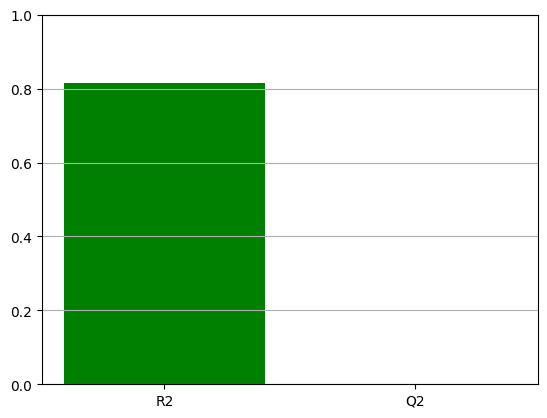

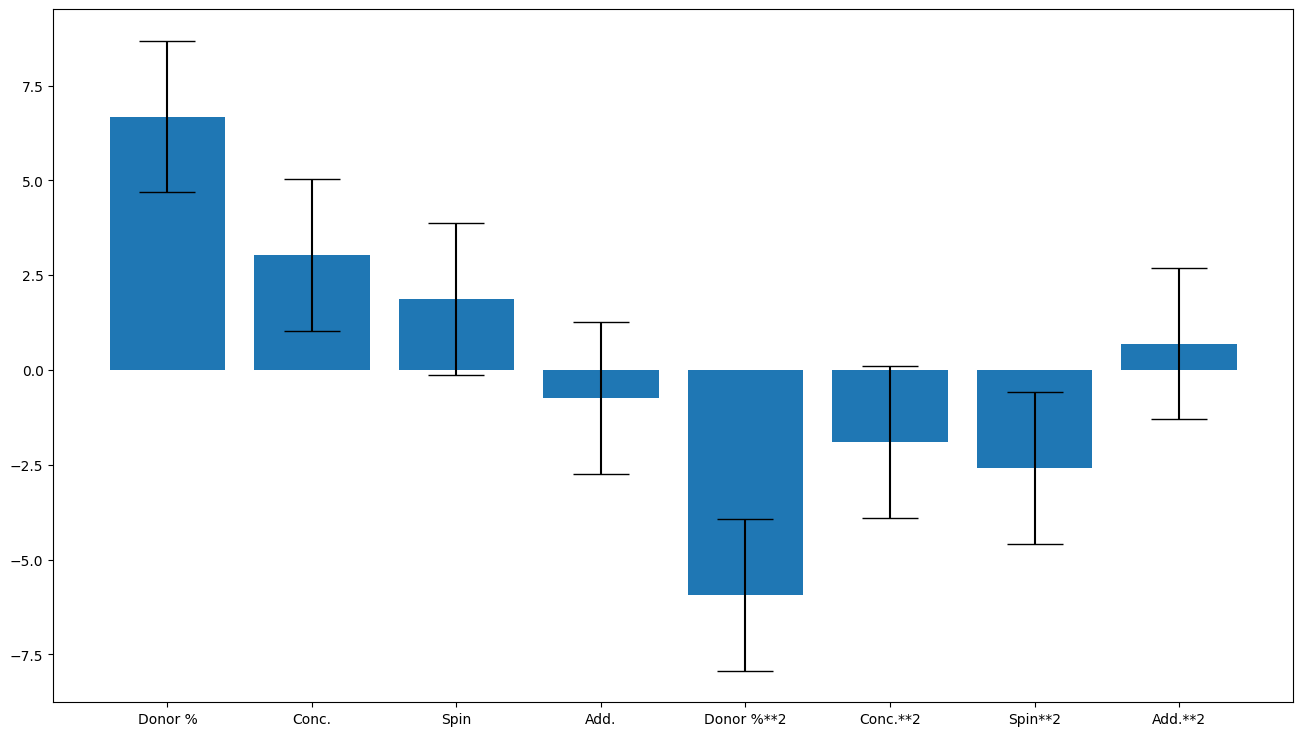

In [8]:
# This time we only want to select some columns and we want it to scale each column so the values are normalised
# across columns.
# First make a list of the columns we want
input_selector = [
    "Donor %",
    "Conc.",
    "Spin",
    "Add.",
    "Donor %**2",
    "Conc.**2",
    "Spin**2",
    "Add.**2",
]
# Note we could also use list indices like this:
# input_selector = [0, 1, 2, 3, 4, 5, 6, 7]

# Then filter the dataset to just take those columns
dataset = (
    doenut.data.ModifiableDataSet(sat_inputs_orig, responses)
    .filter(input_selector)
    .scale()
)
# make and fit and averaged model
model = doenut.models.AveragedModel(
    dataset, scale_run_data=True, drop_duplicates="no"
)
# get the R^2 and Q^2 values
r2, q2 = model.r2, model.q2

# print and plot
print(f"R2 is {r2:.2}, Q2 is {q2:.2}")
doenut.plot.plot_summary_of_fit_small(r2, q2)
doenut.plot.coeff_plot(
    model.coeffs,
    labels=list(dataset.get().inputs.columns),
    errors="p95",
    normalise=True,
)

The fully saturated model isn't very good, so we try backwward feature selection.

Let's try with a different label selection, removing the most obviously insignificant terms.

R2 is 0.81, Q2 is 0.33
Input_selector was: [0, 1, 2, 3, 4, 5]
Average coefficients are: [10.24376537  4.00601457  2.41963174 -9.66908521 -2.52406376 -3.51264286]
Errors are [2. 2. 2. 2. 2. 2.]
Coefficient labels are: ['Donor %', 'Conc.', 'Spin', 'Donor %**2', 'Conc.**2', 'Spin**2']


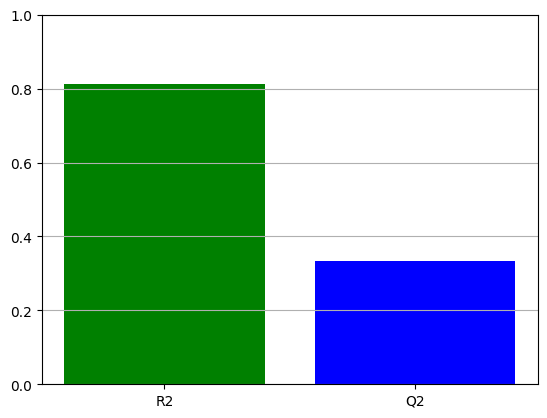

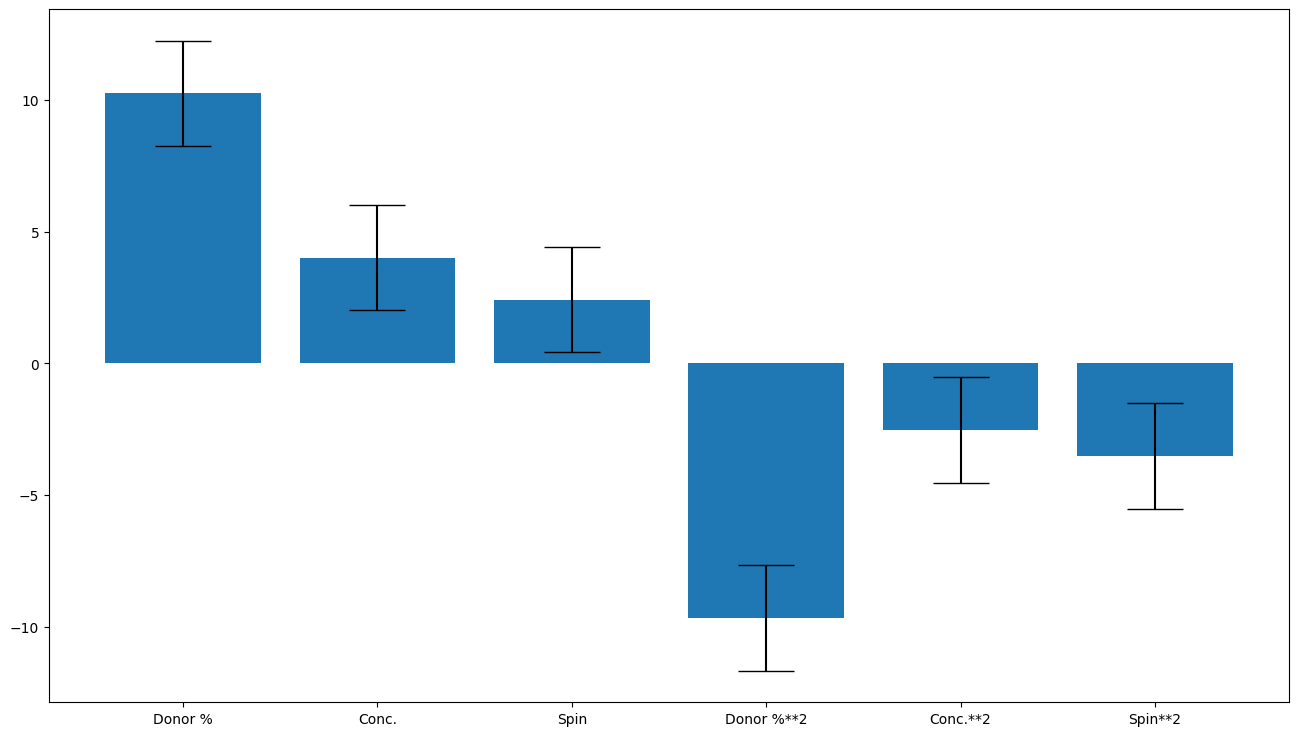

In [9]:
# we removed terms 3 and 7
input_selector = [0, 1, 2, 4, 5, 6]
# refilter the dataset
dataset = (
    doenut.data.ModifiableDataSet(sat_inputs_orig, responses)
    .filter(input_selector)
    .scale()
)
# train a new model
model = doenut.models.AveragedModel(
    dataset, scale_run_data=True, drop_duplicates="no"
)
# plot
r2, q2 = model.r2, model.q2

print(f"R2 is {r2:.2}, Q2 is {q2:.2}")
doenut.plot.plot_summary_of_fit_small(r2, q2)
doenut.plot.coeff_plot(
    model.coeffs,
    labels=list(dataset.get().inputs.columns),
    errors="p95",
    normalise=True,
)

### Results

15 datapoints so we have 14 degrees of freedom (DoF).

Starting from square model

| No. of terms | DoF   | term removed | factor removed | $R^2$  |  $Q^2$ |
|--------------|-------|--------------|----------------|--------|--------|
| 8            | 6     |              |                | 0.815  | -0.176 |
| 7            | 7     | 8            | `Add.**2`      | 0.813  | 0.086  |
| 6            | 8     | 3            | `Add.`         | 0.813  | 0.332  |

this is the model with no statistically insignificant terms. It's heirarchical. 

The $Q^2$ is better than the main effects only model

### Answers 

#### Question 2.1 What terms are in a square model before you optimise the model? (1 mark)

**Answer: D.** A square model adds in square terms for each of the factors, so we have the four main terms and the four square terms. 

* **D**. Donor, Conc., Spin, Add, Donor$^2$, Conc.$^2$, Spin$^2$, Add$^2$

  
#### Question 2.2. What is a **parsimonious** model? (1 mark)

**Answer: E.** A parsimonious model tries to fit the data using as few variables as possible. This may be done by removing the statistically insignificant terms, but its does not have to be, you can remove statistically significant ones if you want. It is usually done to give a higher $Q^2$ but that is not part of the definition of a parsimonious model. It may contain any type of terms.  

* **E**. A model which tries to fit the data well using a few factors as possible


* #### Question 2.3. What is a **heirarchical** model? (1 mark)

**Answer: B.** The model is built up such that the higher order terms are derived from the lower orders ones. 

* **B**. A model where a lower order term (e.g. a linear term or main term) must be present in the model if a higher order term (e.g. square or interaction term) is present.

#### Question 2.4 What terms are in the quadratic parsimonious hierarchical model (i.e. after you optimise the model)? (2 marks)

**Answer: F.** We start from the saturated square model which has the terms: Donor, Conc., Spin, Add, Donor$^2$, Conc.$^2$, Spin$^2$, Add$^2$, this model has a $R^2$ of 0.815 and $Q^2$ of -0.176. The smallest statistically insignificantly different from zero term is Add$^2$, so we remove it, this improves the model, as we now have a $R^2$ of 0.813 and $Q^2$ of 0.086. At this point, there is only one term that is statistically insignificantly different from 0, and that is Add. This is a main effect, but we can remove as there are no higher order terms that rely in it (as we’ve just removed the Add$^2$ term which did). We remove this term and we now have a $R^2$ of 0.813 and a $Q^2$ of 0.332. At this point, all the terms are statistically significant, so we stop here, leaving a model with the terms Donor, Conc., Spin, Donor$^2$, Conc.$^2$, Spin$^2$

* **F**  Donor, Conc., Spin, Donor$^2$, Conc.$^2$, Spin$^2$


#### Question 2.5: What is the $Q^2$ of the final quadratic parsimonious hierarchical model you’ve built? (1 mark)

**Answer: C.**

* **C.**	0.332


## Task 3. Create a parsimonious interaction model (5 marks)

Create **hierarchical, parsimonious, interaction** model. Starting with an **interaction model**, and making sure that all models are hierarchical, optimise the model by removing **only** the **statistically insignificant** terms. Keep a note of the terms removed and the $Q^2$ and $R^2$ values.


#### Question 3.1 What terms are in the parsimonious hierarchical interaction model (i.e. after you optimise the model)? (2 marks)

* **A**. Donor, Conc, Spin, Donor$^2$, Donor$\times$Spin, Conc.$\times$Spin
* **B**. Donor, Conc., Spin, Add, Donor$\times$Spin, Donor$\times$Add
* **C**. Donor, Conc., Spin and Add
* **D**. Donor, Conc., Spin, Add, Donor$^2$, Conc.$^2$, Spin$^2$, Add$^2$
* **E**. Donor, Conc., Spin, Add, Donor$^2$, Conc.$^2$, Spin$^2$, Add$^2$, Donor$\times$Conc., Donor$\times$Spin, Donor$\times$Add, Conc$\times$Spin, Conc.$\times$Add, Spin$\times$Add
* **F**  Donor, Conc., Spin, Donor$^2$, Conc.$^2$, Spin$^2$
* **G**. Donor, Conc., Spin, Add, Donor$\times$Conc., Donor$\times$Spin, Donor$\times$Add, Conc$\times$Spin, Conc.$\times$Add, Spin$\times$Add

#### Question 3.2: What is the Q2 of the parsimonious, hierarchical interaction model? (1 mark)

* **A.** 1
* **B.** -1.79
* **C.** 0.777
* **D.** 0.315
* **E.** 0.761
* **F.** -0.555


#### Question 3.3. Which of the models you have trained so far is the best, and why? (1 mark)

* **A.** The linear model as it is nice and simple (has the smallest number of terms)
* **B.** The saturated quadratic model as it has the best $R^2$
* **C.** The parsimonious quadratic model as it has the best $Q^2$
* **D.** The saturated interaction model as it has interaction terms in it, which we need as there are interactions between the factors that control the width of the hetereojunction material.

### Solution

First we create the full interaction model, then we remove the insignificant terms

R2 is 0.81, Q2 is -2.0
Input_selector was: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Average coefficients are: [-2.35957564  0.3992446  -1.86809132  0.87292737  1.4938505   3.84425325
  1.29341948  1.05388804 -0.52185966 -0.78222527]
Errors are [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
Coefficient labels are: ['Donor %', 'Conc.', 'Spin', 'Add.', 'Donor %*Conc.', 'Donor %*Spin', 'Donor %*Add.', 'Conc.*Spin', 'Conc.*Add.', 'Spin*Add.']


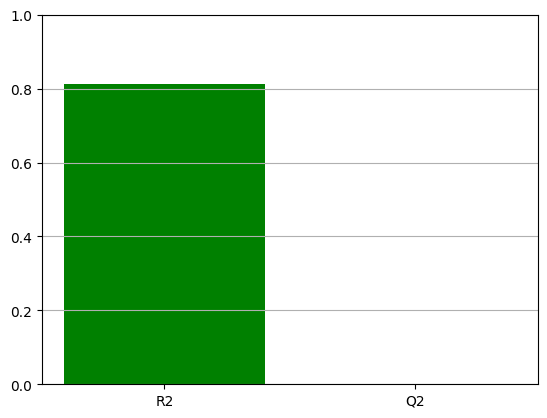

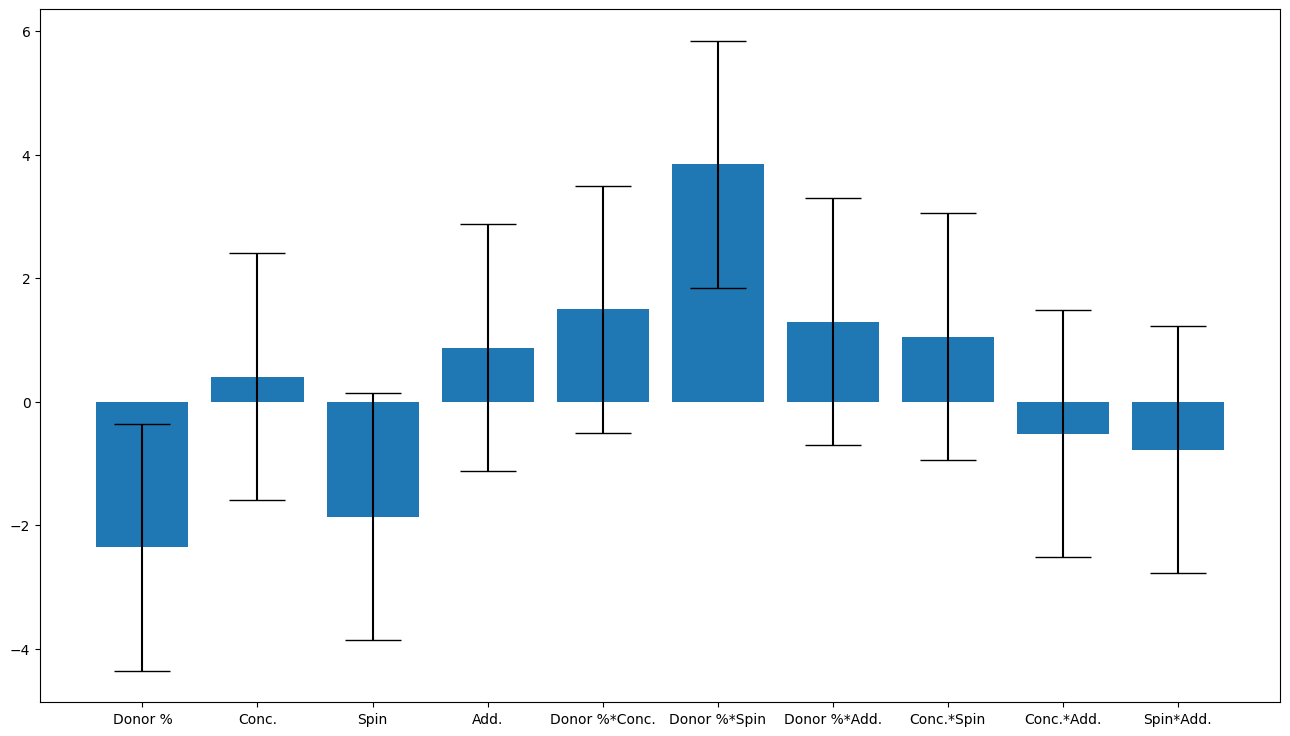

In [10]:
## this is the full interactioin mode.
input_selector = ['Donor %', 'Conc.', 'Spin', 'Add.',
    'Donor %*Conc.', 'Donor %*Spin', 'Donor %*Add.',
       'Conc.*Spin', 'Conc.*Add.', 'Spin*Add.']

dataset = (
    doenut.data.ModifiableDataSet(sat_inputs_orig, responses)
    .filter(input_selector)
    .scale()
)

model = doenut.models.AveragedModel(
    dataset, scale_run_data=True, drop_duplicates="no"
)

r2, q2 = model.r2, model.q2

print(f"R2 is {r2:.2}, Q2 is {q2:.2}")
doenut.plot.plot_summary_of_fit_small(r2, q2)
doenut.plot.coeff_plot(
    model.coeffs,
    labels=list(dataset.get().inputs.columns),
    errors="p95",
    normalise=True,
)

R2 is 0.76, Q2 is 0.31
Input_selector was: [0, 1, 2, 3, 4, 5]
Average coefficients are: [-4.40855184 12.50737559 -5.89083153 -2.40532637  6.88426335  6.80094347]
Errors are [2. 2. 2. 2. 2. 2.]
Coefficient labels are: ['Donor %', 'Conc.', 'Spin', 'Add.', 'Donor %*Spin', 'Donor %*Add.']


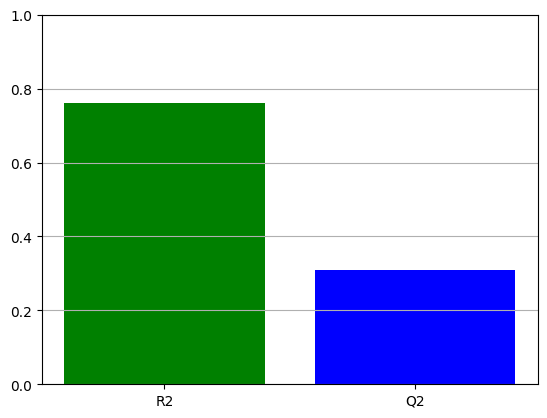

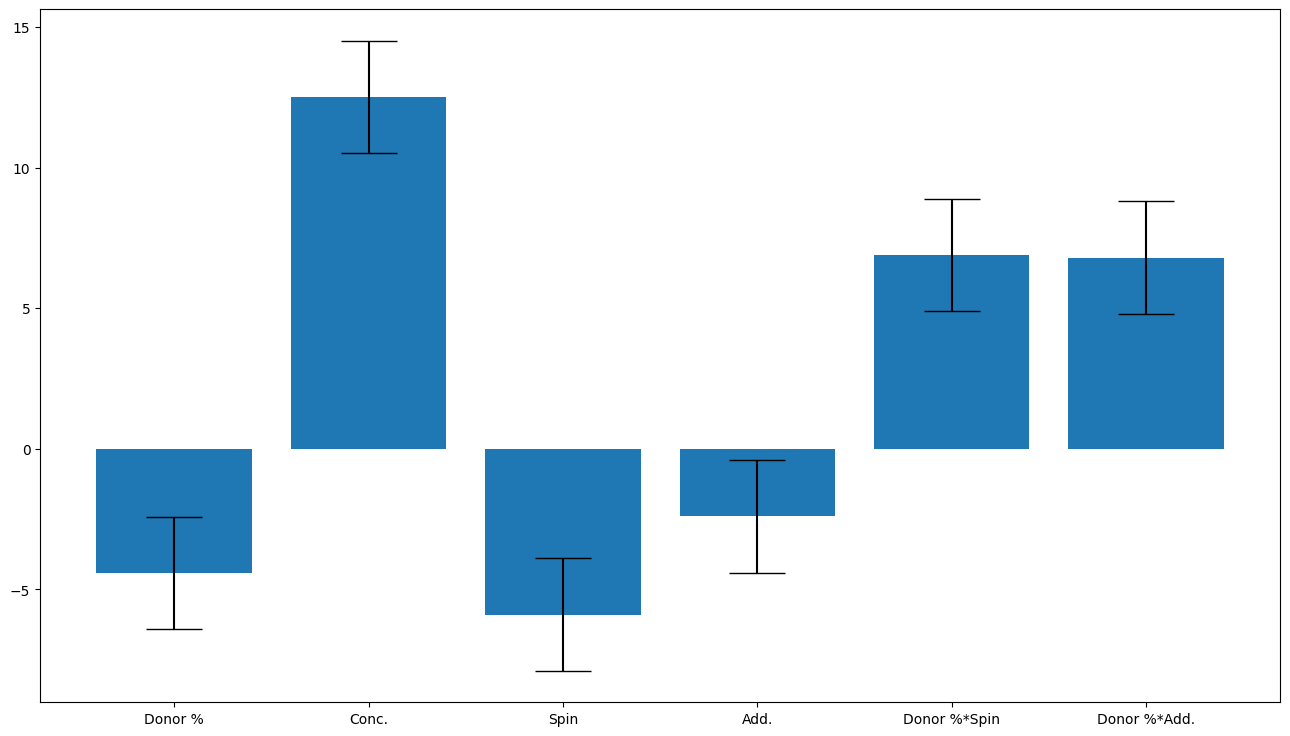

In [11]:
# this is after removing insignificant terms

input_selector = [0, 1, 2, 3, 9, 10]

dataset = (
    doenut.data.ModifiableDataSet(sat_inputs_orig, responses)
    .filter(input_selector)
    .scale()
)

model = doenut.models.AveragedModel(
    dataset, scale_run_data=True, drop_duplicates="no"
)

r2, q2 = model.r2, model.q2

print(f"R2 is {r2:.2}, Q2 is {q2:.2}")
doenut.plot.plot_summary_of_fit_small(r2, q2)
doenut.plot.coeff_plot(
    model.coeffs,
    labels=list(dataset.get().inputs.columns),
    errors="p95",
    normalise=True,
)


15 terms so 14 DoF

Starting from full interaction model

| No. of terms | DoF   | term removed | factor removed | $R^2$  |  $Q^2$ |
|--------------|-------|--------------|----------------|--------|--------|
| 10           | 4     |              |                | 0.811  |  -1.79 |
| 9            | 5     |      12      | `Conc.*Add.`   | 0.813  | 0.0863 |
| 8            | 6     |      13      | `Spin*Add.`  | 0.798  | -0.555 |
| 7            | 7     |      11      | `Conc*Spin.`   | 0.777  | 0.0133 |
| 6            | 8     |      8       | `Donor*Conc.`  | 0.760  | 0.310  | 

this is the model with no statistically insignificant terms. It's hierarchical. 

The $Q^2$ is better than the main effects only model, but not as good as the parsiminious square terms model. 

### Answers: 

#### Question 3.1 What terms are in the parsimonious hierarchical interaction model (i.e. after you optimise the model)? (2 marks)

**Answer: B.** We start from a full interaction model and remove Conc$\times$Add to get a $Q^2$ of 0.086. Then we removed Spin$\times$Add to get a $Q^2$ of -0.555. Then we remove Conc.$\times$Spin (it’s just slightly smaller than the next term) to get a $Q^2$ of 0.0133, then we remove Donor$\times$Conc. To get a $Q^2$ of 0.315. There are now no more statistically insignificant terms to remove, so we stop here. This leaves us with the following terms: Donor, Conc., Spin, Add, Donor$\times$Spin, Donor$\times$Add.

* **B**. Donor, Conc., Spin, Add, Donor$\times$Spin, Donor$\times$Add

#### Question 3.2: What is the $Q^2$ of the parsimonious, hierarchical interaction model? (1 mark)

**Answer: D**

* **D.** 0.315

#### Question 3.3. Which of the models you have trained so far is the best, and why? (1 mark)

**Answer: C.** The parsimonious quadratic model has the best $Q^2$ so we expect it to do the best job of predicting the PCE for new devices, and this is what we want to do. The saturated square model has the best $R^2$, which makes it the best at fitting the data we have, but as the $Q^2$ is so small it is overtrained and thus not likely to be useful for predicting the PCE of new devices. The linear model is simple, but it is too simple as it is missing the higher order effects, which we know are important as the higher order models have a higher $Q^2$ than the linear model. 

* **C.** The parsimonious quadratic model as it has the best $Q^2$


## Task 4: Combine data from both experiments and train a parsimonious model (5 marks)

The scientists decided to do a second experiment to optimise the system. They choose to keep only three of the main effects, and then decide to investigate these factors at three different levels, running a further twelve experiments. Import this new data, combine it with the data from the first experiment and then train a parsimonious, hierarchical model. (N.B. in the paper they use machine learning, here we will stick with the simpler linear regression models used in DoE).  

You will have to drop a column from the first input dataframe so both sets of input data have only 3 factors and then concatenate the dataframes.

You will then need to remake the saturated input dataframe as well.

You will want to start with a full saturated model and then remove the statistically insignificant terms.

Then answer the questions.

#### Question 4.1 From looking at your models from task 2 and task 3, which factor would you chose to drop and why? (1 marks)

* **A.** Donor: Because it is the cross terms in the interaction model 
* **B.** Conc. Because there are no interaction terms containing Conc.
* **C.** Spin. Because Spin$^2$ was the largest quadratic term
* **D.** Add. Because it’s the smallest main effect in the interaction model
* **E.** Donor: because it is the smallest main effect in the interaction model
* **F.** Conc. Because it’s the largest main effect in the interaction model
* **G.** Spin. Because it is the smallest main effect in the quadratic model
* **H.** Add. Because it was removed from the best model


#### Question 4.2 For the second experiment, (solar_cells_2), where the scientists decided to use three factors at three levels, if they had chosen to do a full factorial experiment, rather than a fractional factorial experiment, excluding repeats and centrepoints, how many experiments would they have had to do?  (1 mark)

* **A.** 16
* **B.** 27
* **C.** 9
* **D.** 128
* **E.** 15

#### Question 4.3 What terms are in the saturated model (i.e. before you optimise the model)? (1 mark)

* **A**. Donor, Conc, Spin, Donor$^2$, Donor$\times$Spin, Conc.$\times$Spin
* **B**. Donor, Conc., Spin, Add, Donor$\times$Spin, Donor$\times$Add
* **C**. Donor, Conc., Spin and Add
* **D**. Donor, Conc., Spin, Add, Donor$^2$, Conc.$^2$, Spin$^2$, Add$^2$
* **E**. Donor, Conc., Spin, Add, Donor$^2$, Conc.$^2$, Spin$^2$, Add$^2$, Donor$\times$Conc., Donor$\times$Spin, Donor$\times$Add, Conc$\times$Spin, Conc.$\times$Add, Spin$\times$Add
* **F**  Donor, Conc., Spin, Donor$^2$, Conc.$^2$, Spin$^2$
* **G**. Donor, Conc., Spin, Add, Donor$\times$Conc., Donor$\times$Spin, Donor$\times$Add, Conc$\times$Spin, Conc.$\times$Add, Spin$\times$Add

#### Question 4.4 What terms are in the parsiminious saturated model (i.e. after you optimise the model)? (1 mark)

* **A**. Donor, Conc, Spin, Donor$^2$, Donor$\times$Spin, Conc.$\times$Spin
* **B**. Donor, Conc., Spin, Add, Donor$\times$Spin, Donor$\times$Add
* **C**. Donor, Conc., Spin and Add
* **D**. Donor, Conc., Spin, Add, Donor$^2$, Conc.$^2$, Spin$^2$, Add$^2$
* **E**. Donor, Conc., Spin, Add, Donor$^2$, Conc.$^2$, Spin$^2$, Add$^2$, Donor$\times$Conc., Donor$\times$Spin, Donor$\times$Add, Conc$\times$Spin, Conc.$\times$Add, Spin$\times$Add
* **F**  Donor, Conc., Spin, Donor$^2$, Conc.$^2$, Spin$^2$
* **G**. Donor, Conc., Spin, Add, Donor$\times$Conc., Donor$\times$Spin, Donor$\times$Add, Conc$\times$Spin, Conc.$\times$Add, Spin$\times$Add

### Task 4: Solution

In [12]:
# first read in the data from the second experiment
df = pd.read_csv("data/solar_cells_2.csv")
df

,experiment #,donor %,total concentration,spin speed,PCE,thickness,number of devices
0,NaN,wt %,mg/mL,rpm,%,nm,NaN
1,2-1,20,20,1500,6.32,73,5.0
2,2-2,27,20,1500,7.21,77,11.0
3,2-3,20,25,1500,6.83,126,6.0
4,2-4,27,25,1500,6.96,131,6.0
5,2-5,20,23,1000,7.77,109,4.0
6,2-6,27,23,1000,6.87,136,4.0
7,2-7,20,23,2000,6.43,76,8.0
8,2-8,27,23,2000,7.65,88,7.0
9,2-9,25,20,1000,7.43,115,4.0


In [13]:
# Make the new inputs dataframe
inputs_2 = pd.DataFrame(
    {
        "Donor %": [float(x) for x in df.iloc[1:-1, 1]],
        "Conc.": [float(x) for x in df.iloc[1:-1, 2]],
        "Spin": [float(x) for x in df.iloc[1:-1, 3]],
    }
)
inputs_2

,Donor %,Conc.,Spin
0,20.0,20.0,1500.0
1,27.0,20.0,1500.0
2,20.0,25.0,1500.0
3,27.0,25.0,1500.0
4,20.0,23.0,1000.0
5,27.0,23.0,1000.0
6,20.0,23.0,2000.0
7,27.0,23.0,2000.0
8,25.0,20.0,1000.0
9,25.0,25.0,1000.0


In [14]:
# Make the new responses dataframe
responses_2 = pd.DataFrame({"PCE": [float(x) for x in df["PCE"][1:-1]]})
responses_2

,PCE
0,6.32
1,7.21
2,6.83
3,6.96
4,7.77
5,6.87
6,6.43
7,7.65
8,7.43
9,6.88


### Building a combined dataset

In [15]:
# now we want to concatanate the dataframes together, only taking the columns Donor %, Conc., and Spin
new_inputs = pd.concat(
    [inputs[["Donor %", "Conc.", "Spin"]], inputs_2], axis=0
)
new_responses = pd.concat([responses, responses_2], axis=0)

In [16]:
new_inputs

,Donor %,Conc.,Spin
0,10.0,20.0,3000.0
1,10.0,25.0,1000.0
2,10.0,10.0,600.0
3,10.0,15.0,2000.0
4,25.0,20.0,600.0
5,25.0,15.0,1000.0
6,25.0,10.0,3000.0
7,25.0,25.0,2000.0
8,40.0,10.0,1000.0
9,40.0,20.0,2000.0


In [17]:
# build a new saturated inputs
sat_source_list = []
source_list = []
sat_inputs_2, sat_source_list = doenut.add_higher_order_terms(
    new_inputs, add_squares=True, add_interactions=True, column_list=[]
)

### Train a saturated model: 9 terms

R2 is 0.89032119443045, Q2 is -0.22579296419548922
Input_selector was: [0, 1, 2, 3, 4, 5, 6, 7, 8]
Average coefficients are: [ 2.50008245  2.4484955   0.19604689 -5.11218527 -2.8778947  -2.48480065
 -1.28965495  0.90939463  0.78220542]
Errors are [2. 2. 2. 2. 2. 2. 2. 2. 2.]
Coefficient labels are: ['Donor %', 'Conc.', 'Spin', 'Donor %**2', 'Conc.**2', 'Spin**2', 'Donor %*Conc.', 'Donor %*Spin', 'Conc.*Spin']


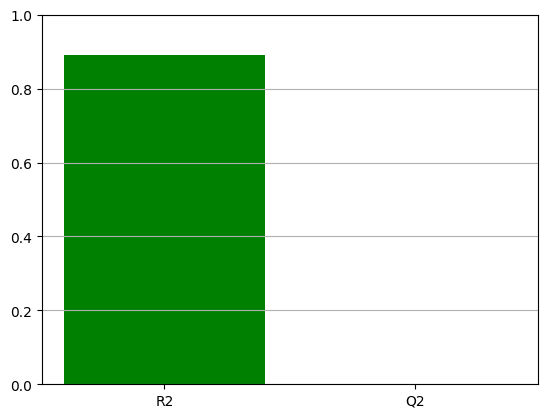

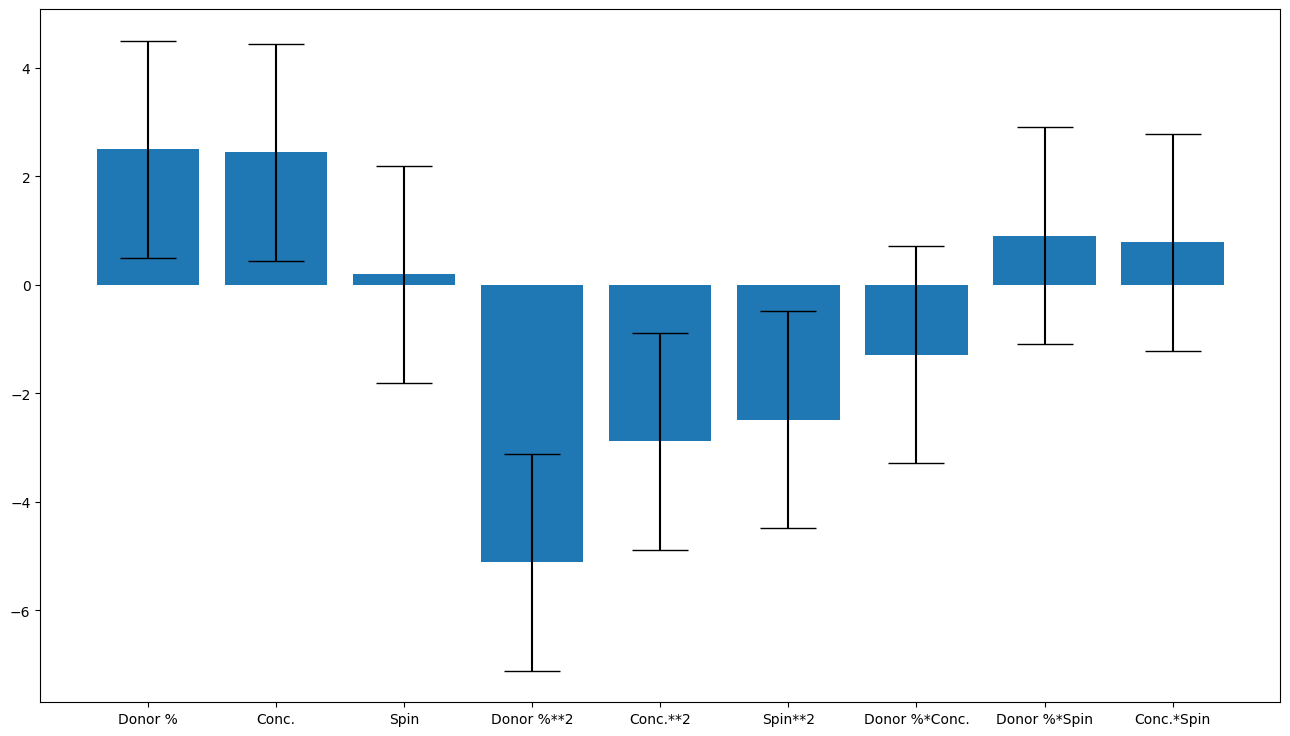

In [18]:
input_selector = [0, 1, 2, 3, 4, 5, 6, 7, 8]

dataset = doenut.data.ModifiableDataSet(sat_inputs_2, new_responses).filter(
    input_selector
)

model = doenut.models.AveragedModel(
    dataset, scale_data=True, drop_duplicates="no"
)

r2, q2 = model.r2, model.q2

print(f"R2 is {r2}, Q2 is {q2}")
doenut.plot.plot_summary_of_fit_small(r2, q2)
doenut.plot.coeff_plot(
    model.coeffs,
    labels=list(dataset.get().inputs.columns),
    errors="p95",
    normalise=True,
)

### Optimised parsimonious model

Removing the terms in order gives you:

R2 is 0.8712066982581048, Q2 is 0.694935358775664
Input_selector was: [0, 1, 2, 3, 4, 5]
Average coefficients are: [ 13.51406635   7.52612545   4.90682899 -14.54539532  -5.32766778
  -6.36236656]
Errors are [2. 2. 2. 2. 2. 2.]
Coefficient labels are: ['Donor %', 'Conc.', 'Spin', 'Donor %**2', 'Conc.**2', 'Spin**2']


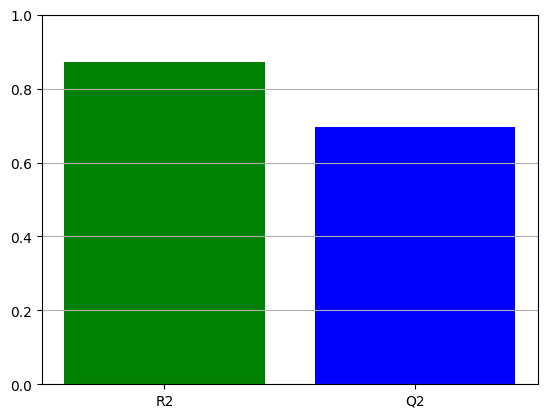

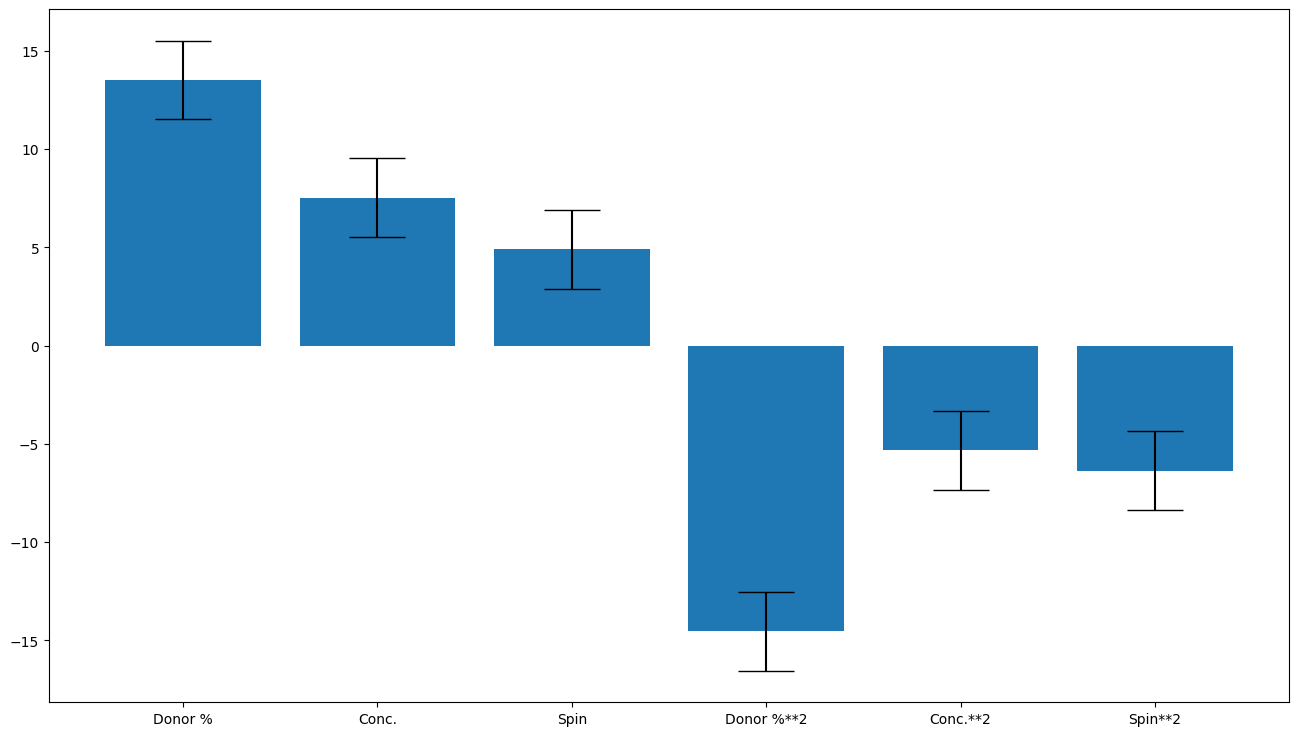

In [19]:
input_selector = [0, 1, 2, 3, 4, 5]

dataset = doenut.data.ModifiableDataSet(sat_inputs_2, new_responses).filter(
    input_selector
)

model = doenut.models.AveragedModel(
    dataset, scale_data=True, drop_duplicates="no"
)

r2, q2 = model.r2, model.q2

print(f"R2 is {r2}, Q2 is {q2}")
doenut.plot.plot_summary_of_fit_small(r2, q2)
doenut.plot.coeff_plot(
    model.coeffs,
    labels=list(dataset.get().inputs.columns),
    errors="p95",
    normalise=True,
)

### Results


| No. of terms | DoF   | term removed | factor removed | $R^2$  |  $Q^2$ |
|--------------|-------|--------------|----------------|--------|--------|
| 9            |   17  |              |                | 0.89   | -0.425 |
| 8            |   18  |    8         | `Conc.*Spin`   | 0.887. | 0.44   |
| 7            |   19  |    7         | `Donor*Spin`   | 0.88   | 0.535  |
| 6            |   20  |    6         | `Donor* Conc`  | 0.871  | 0.695  | 

### Answers

#### Question 4.1 From looking at your models from task 2 and task 3, which factor would you chose to drop and why? (1 marks)

**Answer: H.** The additive term (`Add`) should have been removed from the square model as both the Add$^2$ and Add terms are statistically insignificant, and as this is the better of the two models, it suggests that Add can be ignored in further investigations of the system. 

* **H.** Add. Because it was removed from the best model

#### Question 4.2 For the second experiment, (solar_cells_2), where the scientists decided to use three factors at three levels, if they had chosen to do a full factorial experiment, rather than a fractional factorial experiment, excluding repeats and centrepoints, how many experiments would they have had to do?  (1 mark)

**Answer: B.** 27, three levels and three factors is $3^3$ or 27 experiments. 

* **B.** 27

#### Question 4.3 What terms are in the saturated model (i.e. before you optimise the model)? (1 mark)

**Answer: E.** The saturated model contains all possible terms of order up to 2, i.e. all the main terms, all the interaction terms and all the square terms.

* **E**. Donor, Conc., Spin, Add, Donor$^2$, Conc.$^2$, Spin$^2$, Add$^2$, Donor$\times$Conc., Donor$\times$Spin, Donor$\times$Add, Conc$\times$Spin, Conc.$\times$Add, Spin$\times$Add

#### Question 4.4 What terms are in the parsiminious saturated model (i.e. after you optimise the model)? (1 mark)

**Answer: F.** All the cross-terms are removed in the following order: Conc$\times$Spin, Donor$\times$Spin, Donor$\times$Conc, this gives us an $R^2$ of 0.871 and $Q^2$ of 0.695. It's the same factors that were found to be significant in the square model.

* **F**  Donor, Conc., Spin, Donor$^2$, Conc.$^2$, Spin$^2$


## Task 5: Optimising the devices. Using the best model that you have trained (as measured by $Q^2$), find some conditions to optimise the devices.

One way to do this is to plot a 4D contour plot with Donor on the $x$ axis, Conc. On the $y$ axis and Spin as the constant slices (i.e. `x_key` is the donor %, `y_key` is the concentration and `c_key` is the spin). 
.
The other way is to feed the data into the best model directly, I would suggest looking a`t doenut.predict_from_mod()`l.


#### Question 5.1: Which model is the best? Which model have you chosen to use? (1 mark)

* **A.** The linear (main effects) model from task 1
* **B.** The full square model from task 2 (pre-optimisation)
* **C.** The parsimonious square model from task 2 (post-optimisation)
* **D.** The full interaction model from task 3 (pre-optimisation)
* **E.** The parsimonious interaction model from task 3 (post-optimisation)
* **F.** The saturated model from task 4 (pre-optimisation)
* **G.** The parsimonious model from task 4 (post-optimisation)


#### Question 5.2: What conditions will give a device with a power conversion efficiency (PCE) of above 7%? (4 marks)

* **A.**	`Donor %`: 20, `Conc.`: 12, `Spin`:  500,
* **B.**	`Donor %`: 40, `Conc.`: 16, `Spin`:  1500,
* **C.**	`Donor %`: 35, `Conc.`: 22, `Spin`:  1500,
* **D.**	`Donor %`: 45, `Conc.`: 18, `Spin`:  2500,
* **E.**	`Donor %`: 20, `Conc.`: 17, `Spin`:  2500

## Task 5. solution

### Method 1: Plot a 4-D contour plot and read the values off:

The 4D contour plot loops over a large number of possible values and then produces a contourplot of the response surface which relates the input to the response. 

<Figure size 2000x1200 with 0 Axes>

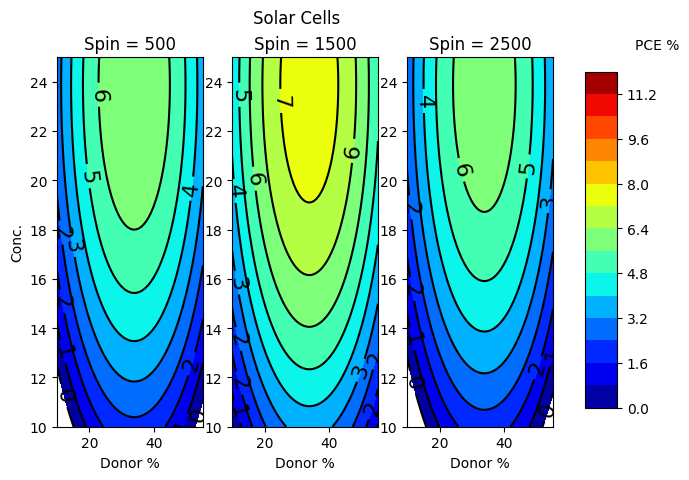

In [20]:
# Write a function to tell the contour plot how to get the final dataframe
# we need the square terms, so we just multiply the columns by themselves
def my_function(df_1):
    # write the formulae for the dataframe you ended up with
    df_1["Donor %**2"] = df_1["Donor %"] * df_1["Donor %"]
    df_1["Conc.**2"] = df_1["Conc."] * df_1["Conc."]
    df_1["Spin**2"] = df_1["Spin"] * df_1["Spin"]

    return df_1

# slices
c_key = "Spin"
# y axis
y_key = "Conc."
# x axis
x_key = "Donor %"

doenut.plot.four_D_contour_plot(
    unscaled_model=model.model, # model chosen for predictions (should be the best model)
    x_key=x_key,
    y_key=y_key,
    c_key=c_key,
    x_limits=[inputs[x_key].min(), inputs[x_key].max()], # auto-ccalculate the limits
    y_limits=[inputs[y_key].min(), inputs[y_key].max()],
    constants=[500, 1500, 2500], # values for slices in the c dimension
    n_points=60, # number of points to calculate per axis (i.e. 3600 points per graph)
    my_function=my_function, # function defined abve
    input_selector=[], # all inputs
    fig_label="Solar Cells", # label
    x_label=x_key,
    y_label=y_key,
    constant_label=c_key,
    z_label="PCE %",
    cmap="jet",
    num_of_z_levels=16, # number of contours needed + 1
    z_limits=[0, 12], # min and max range for z (response)
)

From looking at the graph, around 30-35 donor wieght %, high concentration 20-24 mg/ml and spin of 1500rpm gives a PCE above 7%, i.e. the answer is C.

### Method 2. Run the model on the input values: 

We can just put the question answers into our best model as input and see what it predicts.

In [21]:
# put in the suggested answers as a dataframe
question_5p2 = pd.DataFrame(
    {
        "A": {"Donor %": 20, "Conc.": 12, "Spin": 500},
        "B": {"Donor %": 40, "Conc.": 16, "Spin": 1500},
        "C": {"Donor %": 35, "Conc.": 22, "Spin": 1500},
        "D": {"Donor %": 45, "Conc.": 18, "Spin": 2500},
        "E": {"Donor %": 20, "Conc.": 17, "Spin": 2500},
    }
).T

In [22]:
# check it's the right way round (note the transpose in the cell above)
question_5p2

,Donor %,Conc.,Spin
A,20,12,500
B,40,16,1500
C,35,22,1500
D,45,18,2500
E,20,17,2500


In [23]:
question_5p2.index

Index(['A', 'B', 'C', 'D', 'E'], dtype='object')

In [24]:
# make an saturated inputs list from the new data
sat_source_list = []
source_list = []
sat_inputs_q5, sat_source_list = doenut.add_higher_order_terms(
    question_5p2,
    add_squares=True,
    add_interactions=True,
    column_list=[],
)
# put new data into the model to get the predictions
predictions, _ = doenut.predict_from_model(
    model.model, sat_inputs_q5, input_selector
)
letters = [x for x in question_5p2.index]
[print(f"{letters[i]}:\t{predictions[i][0]:.2}% PCE") for i in range(len(letters))];

A:	2.1% PCE
B:	6.1% PCE
C:	7.6% PCE
D:	4.7% PCE
E:	4.0% PCE


Answer C is above 7.

### Answers

#### Question 5.1: Which model is the best? Which model have you chosen to use? (1 mark)

**Answer: G.** The model with the best $Q^2$ is the parsimonious model from task 4. The parsimonious quadratic model from task 2 has the same factors, but it is a not as good a model as it has not been trained on as much data. 

* **G.** The parsimonious model from task 4 (post-optimisation)

#### Question 5.2: What conditions will give a device with a power conversion efficiency (PCE) of above 7%? (4 marks)

**Answer: C.** If you managed to plot the 4D contour plot with this data as described, then you can read these value off the graph. Alternatively, you could have made a dataframe of these options and put them into your model to directly calculate the predictions and see which one is over 7%. 

* **C.**	`Donor %`: 35, `Conc.`: 22, `Spin`:  1500,


## Conclusion

The task was to optimise the PCE % of spun-coated solar cells. A screening experiment was done with 4 factors and 4 levels, using a fractional factorial $4^{(4-2)}$ design. The main effects model was not sufficient. The best model contained only 3 of the 4 factors and their squares. The factor additive was dropped, showing that the amount of additive added to the solution did not effect the PCE % over the range tested. A second experiment was done with a full factorial experiment with three factors at three levels. Combining the data from the two experiments together, a parsiminious model was built, again including only the factors and their squares. Using this model, the best conditions are additive of more than 0, less than 12 % (vol), 30-35 donor % (weight), a concentration 20-24 mg/ml and spin of 1500rpm, which predicts a PCE above 7%.